<a href="https://colab.research.google.com/github/arjay55/CS284_PA3/blob/main/train_valid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [169]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
from torch.utils.tensorboard import SummaryWriter
import time

from packaging import version
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import tensorboard as tb
import cf_matrix
from sklearn.metrics import *

In [3]:
#process run metrics
major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    "This notebook requires TensorBoard 2.3 or later."
print("TensorBoard version: ", tb.__version__)

TensorBoard version:  2.7.0


In [4]:
# experiment_id = "XNEYoN6LSrOzHp8N9cM8Jw"
# experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
# df = experiment.get_scalars()
# df.to_pickle("run_metrics.pickle")

,run,tag,step,value
0,Nov14_14-45-19_DESKTOP-FBNEU12_Dropout_0p3,Accuracy/validation,1,0.570500
1,Nov14_14-45-19_DESKTOP-FBNEU12_Dropout_0p3,Accuracy/validation,2,0.632200
2,Nov14_14-45-19_DESKTOP-FBNEU12_Dropout_0p3,Accuracy/validation,3,0.722900
3,Nov14_14-45-19_DESKTOP-FBNEU12_Dropout_0p3,Accuracy/validation,4,0.750600
4,Nov14_14-45-19_DESKTOP-FBNEU12_Dropout_0p3,Accuracy/validation,5,0.761200
...,...,...,...,...
3701,colab_dropout0,Loss/validation,76,0.804236
3702,colab_dropout0,Loss/validation,77,0.804405
3703,colab_dropout0,Loss/validation,78,0.805041
3704,colab_dropout0,Loss/validation,79,0.804404


In [41]:
dfacc = df[df['tag'].str.endswith("cy/validation")].pivot(index="step", columns="run", values="value")
#select only needed columns

In [42]:
dfacc = dfacc.iloc[:,[6,5,0,1,2,3]]

In [43]:
dfacc.columns = ['d=0','d=0.1','d=0.3','d=0.5','d=0.7','d=0.9']

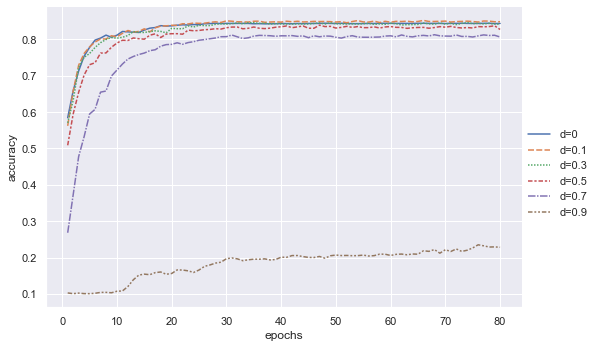

In [39]:
sns.set_theme()
g=sns.relplot(kind="line",data=dfacc,height=5,aspect=1.5)
g.set(xlabel="epochs", ylabel = "accuracy")
g.savefig("acc.pdf")

In [47]:
dflossvalid = df[df['tag'].str.endswith("Loss/validation")].pivot(index="step", columns="run", values="value")
dflossvalid = dflossvalid.iloc[:,[6,5,0,1,2,3]]
dflossvalid.columns = ['d=0','d=0.1','d=0.3','d=0.5','d=0.7','d=0.9']

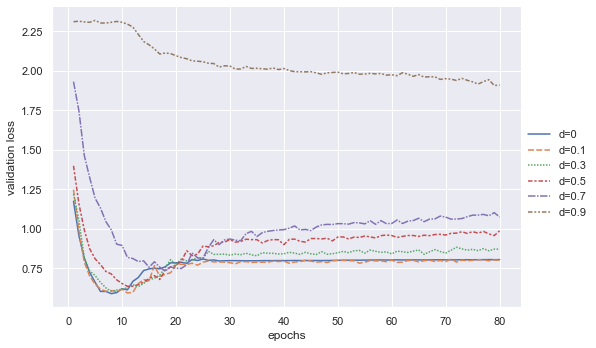

In [48]:
g=sns.relplot(kind="line",data=dflossvalid,height=5,aspect=1.5)
g.set(xlabel="epochs", ylabel = "validation loss")
g.savefig("validloss.pdf")

In [50]:
dflosstrain = df[df['tag'].str.endswith("ss/train")].pivot(index="step", columns="run", values="value")
dflosstrain = dflosstrain.iloc[:,[6,5,0,1,2,3]]
dflosstrain.columns = ['d=0','d=0.1','d=0.3','d=0.5','d=0.7','d=0.9']

In [56]:
dflosstrain['newindex'] = dflosstrain.index.values/5

In [59]:
dflosstrain.set_index("newindex",inplace=True)

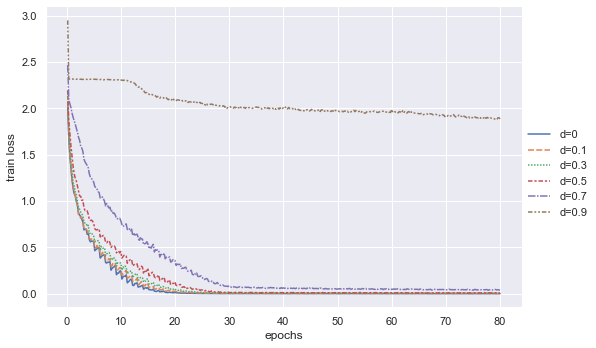

In [61]:
g=sns.relplot(kind="line",data=dflosstrain,height=5,aspect=1.5)
g.set(xlabel="epochs", ylabel = "train loss")
g.savefig("train.pdf")

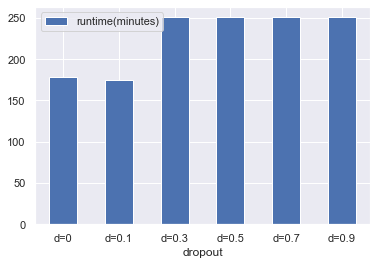

In [67]:
df = pd.DataFrame({'dropout':['d=0', 'd=0.1', 'd=0.3','d=0.5', 'd=0.7', 'd=0.9'], 'runtime(minutes)':[179, 175, 251, 251, 251, 251]})
ax = df.plot.bar(x='dropout', y='runtime(minutes)', rot=0)

In [68]:
def backup(object, filename):
    with open(filename, 'wb') as f:
        pickle.dump(object, f, pickle.HIGHEST_PROTOCOL)

def reload(persist):
    with open(persist, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        data = pickle.load(f)
    return data

In [69]:
path = "."

In [70]:
class PerImageStandardization(object):
      """
      per_image_whitening function equivalent in PyTorch
      """
      def __call__(self, img):

        adjusted_stddev = torch.max(torch.std(img), 1/torch.sqrt(torch.tensor(torch.numel(img))))

        return (img-torch.mean(img))/adjusted_stddev
        
      def __repr__(self):
        return self.__class__.__name__+'()' 

In [71]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.CenterCrop(size=28),
     PerImageStandardization()])

trainset = torchvision.datasets.CIFAR10(root=path, train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [72]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()


# get some random training images
dataiter = iter(trainloader)
data = dataiter.next()
images, labels = data[0].to(device), data[1].to(device)

# show images
# imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

  dog   car  deer   dog  frog horse horse truck plane plane   cat   car horse plane  frog   car


In [75]:

class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
        super().__init__()

        #accessible attributes
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, padding_mode='zeros')
        self.batch = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(self.batch(x))

        return x


In [76]:
class Inception(nn.Module):
    def __init__(self, in_channels, ch1, ch3):
        super().__init__()

        #accessible attributes
        self.ch1 = ch1
        self.ch3 = ch3

        self.convch1 = Conv(in_channels, ch1, 1, 1)
        self.convch3 = Conv(in_channels, ch3, 3, 1, 1)
        
    def forward(self, x):
        ch1features = self.convch1(x)
        ch3features = self.convch3(x)
        x = torch.cat((ch1features,ch3features),1)
        return x


In [77]:
class Downsample(nn.Module):
    def __init__(self, in_channels, ch3):
        super().__init__()

        #accessible attributes
        self.ch3 = ch3

        self.convch3 = Conv(in_channels, ch3, 3, 2)
        self.maxpool = nn.MaxPool2d(3, 2)
        
    def forward(self, x):
        ch3features = self.convch3(x)
        x_maxpool = self.maxpool(x)
        x = torch.cat((ch3features,x_maxpool),1)
        return x


In [78]:
class MiniGoogleNet(nn.Module):
    def __init__(self, in_channels, dropoutval):
        super().__init__()
        
        self.dropoutval = dropoutval

        self.conv_in = Conv(in_channels, 96, 3, 1)

        self.inception1a = Inception(96, 32, 32)
        self.inception1b = Inception(64, 32, 48)
        self.downsample1 = Downsample(32+48, 80)

        self.inception2a = Inception(80+32+48, 112, 48)
        self.inception2b = Inception(112+48, 96, 64)
        self.inception2c = Inception(96+64, 80, 80)
        self.inception2d = Inception(160, 48, 96)
        self.downsample2 = Downsample(48+96, 96)

        self.inception3a = Inception(48+96+96, 176, 160)
        self.inception3b = Inception(176+160, 176, 160)       
        self.meanpool = nn.AdaptiveAvgPool2d(1) #best fit reason
        self.dropout = nn.Dropout(self.dropoutval)
        self.fcout = nn.Linear(176+160, 10)

    def forward(self, x):
        x = self.conv_in(x)

        x = self.inception1a(x)
        x = self.inception1b(x)
        x = self.downsample1(x)

        x = self.inception2a(x)
        x = self.inception2b(x)
        x = self.inception2c(x)
        x = self.inception2d(x)
        x = self.downsample2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.meanpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fcout(x)
        return x


3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [80]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=30, last_epoch=-1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-01.


In [ ]:
# run_suffix = "Dropout_0p9"
# writer = SummaryWriter(comment="_{}".format(run_suffix))
# writer.add_graph(net,images)

Let's quickly save our trained model:



See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
for more details on saving PyTorch models.

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [159]:
PATH='cifar_net_Dropout_0.pth'
net = MiniGoogleNet(3,0)
net.load_state_dict(torch.load(PATH))
net.to(device)

MiniGoogleNet(
  (conv_in): Conv(
    (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1))
    (batch): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (inception1a): Inception(
    (convch1): Conv(
      (conv): Conv2d(96, 32, kernel_size=(1, 1), stride=(1, 1))
      (batch): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (convch3): Conv(
      (conv): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (inception1b): Inception(
    (convch1): Conv(
      (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
      (batch): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (convch3): Conv(
      (conv): Conv2d(64, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, trac

In [160]:

# since we're not training, we don't need to calculate the gradients for our outputs
predicted = []
actual = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # images, labels = data
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predictedx = torch.max(outputs.data, 1)
        actual.extend(list(labels.cpu().numpy()))
        predicted.extend(list(predictedx.cpu().numpy()))



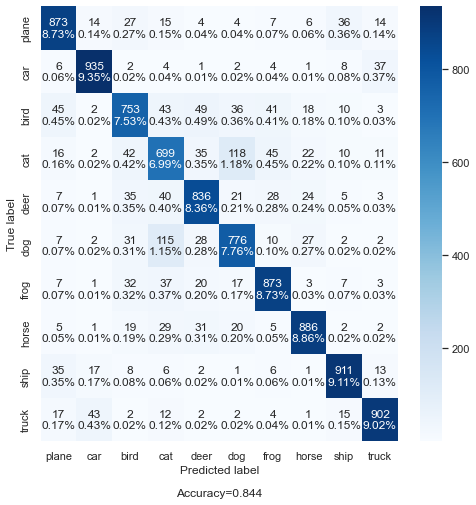

In [161]:
cf_matrix.make_confusion_matrix(confusion_matrix(actual,predicted,labels = range(10)), figsize= (8,8), categories = list(classes))

In [162]:
#compute class accuracy for dropout 0
cf_d0 = confusion_matrix(actual,predicted,labels = range(10))
cf_d0.diagonal()/cf_d0.sum(axis=1)

array([0.873, 0.935, 0.753, 0.699, 0.836, 0.776, 0.873, 0.886, 0.911,
       0.902])

In [170]:
matthews = matthews_corrcoef(actual,predicted)

In [173]:
#compute f1 score
f1_score(actual,predicted, average=None)

array([0.86521308, 0.92666006, 0.77191184, 0.699     , 0.83266932,
       0.77716575, 0.86307464, 0.89089995, 0.90827517, 0.90653266])

In [20]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        # images, labels = data    
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)    
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class plane is: 43.2 %
Accuracy for class car   is: 27.0 %
Accuracy for class bird  is: 7.2 %
Accuracy for class cat   is: 0.5 %
Accuracy for class deer  is: 0.1 %
Accuracy for class dog   is: 66.3 %
Accuracy for class frog  is: 37.8 %
Accuracy for class horse is: 11.8 %
Accuracy for class ship  is: 43.2 %
Accuracy for class truck is: 46.0 %
